In [1]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import loguniform, uniform
import matplotlib.pyplot as plt

In [2]:
# Reproduzierbarkeit
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
df = pd.read_csv("Dataset2.csv")
df = df.sort_values(["Proband", "TestArt", "time (MPM)"]).reset_index(drop=True)
df = (df.groupby(["Proband", "TestArt"], as_index=False, group_keys=False).head(3333))
df.fillna(0, inplace=True)
df.reset_index(drop=True, inplace=True)
#print(df.iloc[3331])

In [4]:
#Feature Engineering
verzögert = 5
delta = 5
roll = 10

wichtige_spalten = ["HR", "speed (m/s)", "Pmet (W/kg)", "acc (m/s2)"]

for spalte in wichtige_spalten:
    gruppiert = df.groupby(["Proband", "TestArt"])[spalte]
    df[f"{spalte}_verzoegerung{verzögert}"] = gruppiert.shift(verzögert)
    df[f"{spalte}_differenz{delta}"] = gruppiert.diff(delta)
    df[f"{spalte}_mittelwert{roll}"] = gruppiert.transform(lambda x: x.rolling(roll, min_periods=1).mean())

# Interaktionsmerkmal
df["HR_Pmet_interaktion"] = df["HR"] * df["Pmet (W/kg)"]
df["speed_acc_interaktion"] = df["speed (m/s)"] * df["acc (m/s2)"]

# Relative Zeit
df["rel_zeit"] = df.groupby(["Proband", "TestArt"])["time (MPM)"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Missing Indicator
df["missing_flag"] = df.isna().any(axis=1).astype("int")
df.ffill(inplace=True)
df.fillna(0, inplace=True)

# Input und mein Target
loesch_spalten = ["measured oxygen uptake (l/min)","new_sim oxygen uptake (l/min)", "original_sim oxygen uptake (l/min)","Proband", "TestArt", "time (MPM)"]
X = df.drop(columns=loesch_spalten).astype("float32").values
y = df["measured oxygen uptake (l/min)"].astype("float32").values
gruppen = df["Proband"].values

In [5]:
pipe = Pipeline([("scaler", StandardScaler()),("svr", SVR(kernel="rbf"))])

parameter = {"svr__C": loguniform(1e0, 1e3),"svr__gamma": loguniform(1e-4, 1e-1),"svr__epsilon": uniform(0.01, 0.35)}

innere_cv = GroupKFold(n_splits=3)

suche = RandomizedSearchCV(estimator=pipe, param_distributions=parameter, n_iter=20, cv=innere_cv,scoring="neg_root_mean_squared_error", n_jobs=-1, random_state=0, verbose=1)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  1 – Proband 1:
 RMSE = 0.348,  R2 = 0.855,  MAPE = 16.78%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


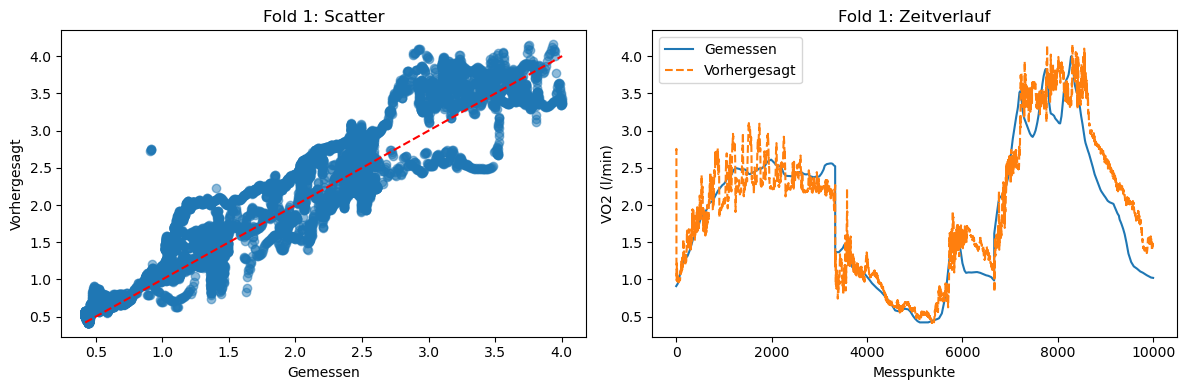

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  2 – Proband 2:
 RMSE = 0.461,  R2 = 0.778,  MAPE = 27.19%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


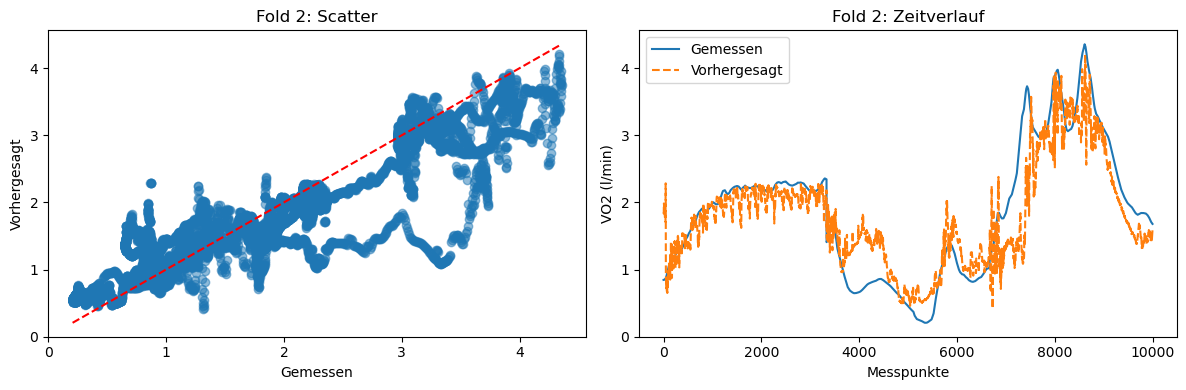

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  3 – Proband 3:
 RMSE = 0.756,  R2 = 0.076,  MAPE = 29.21%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


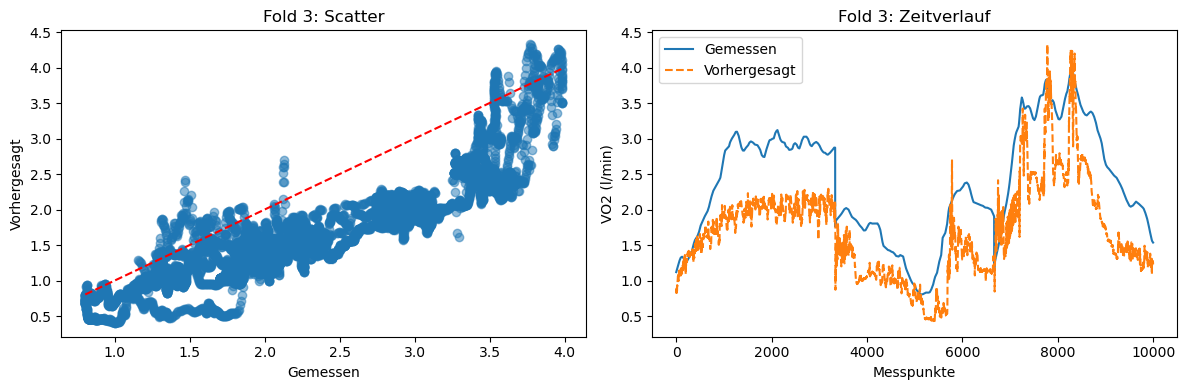

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  4 – Proband 4:
 RMSE = 0.434,  R2 = 0.736,  MAPE = 27.80%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


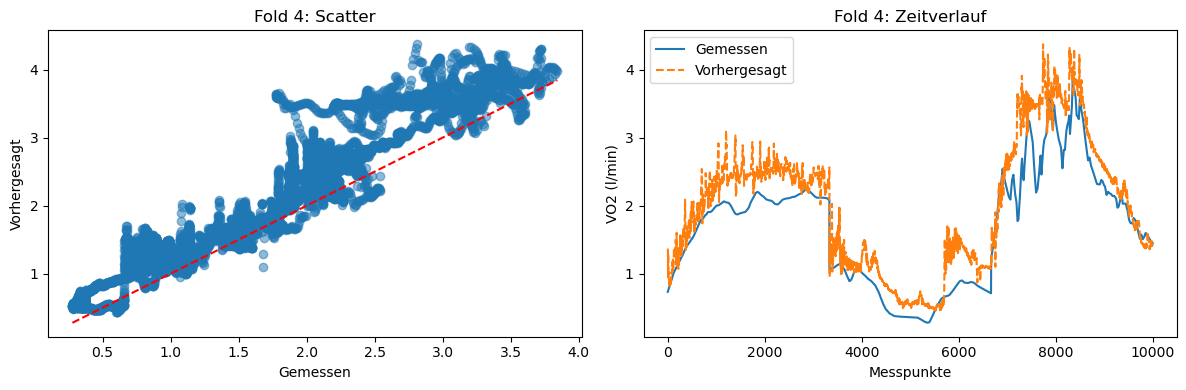

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  5 – Proband 5:
 RMSE = 0.319,  R2 = 0.895,  MAPE = 20.83%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


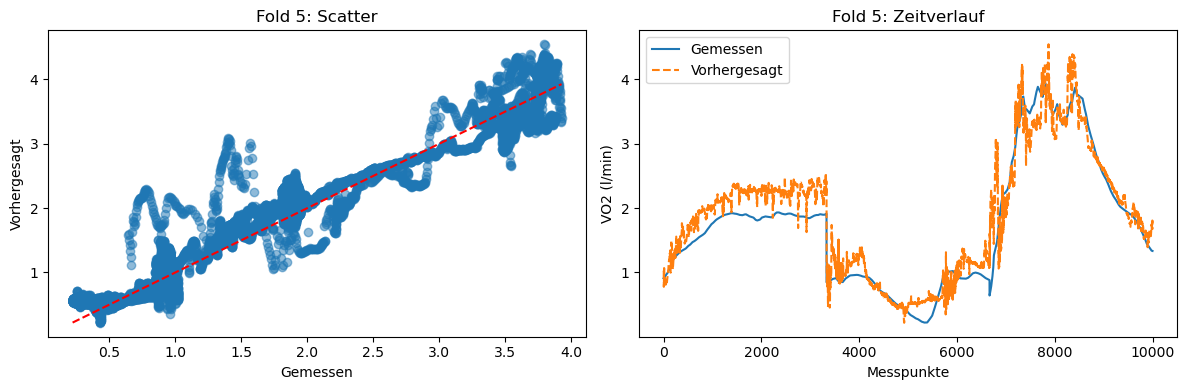

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  6 – Proband 6:
 RMSE = 0.487,  R2 = 0.619,  MAPE = 32.13%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


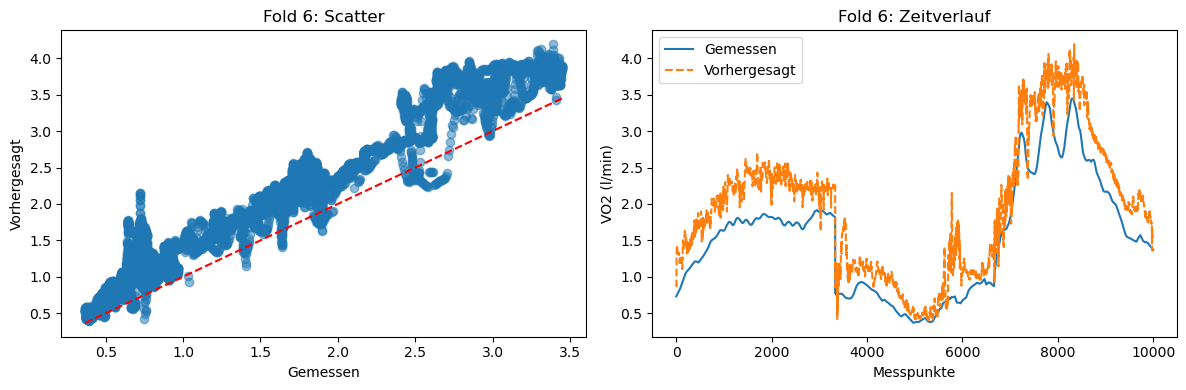

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  7 – Proband 7:
 RMSE = 0.275,  R2 = 0.912,  MAPE = 13.33%
 Beste Parameter: {'svr__C': 43.11710058685489, 'svr__epsilon': 0.15827917976861663, 'svr__gamma': 0.008663279761354562}


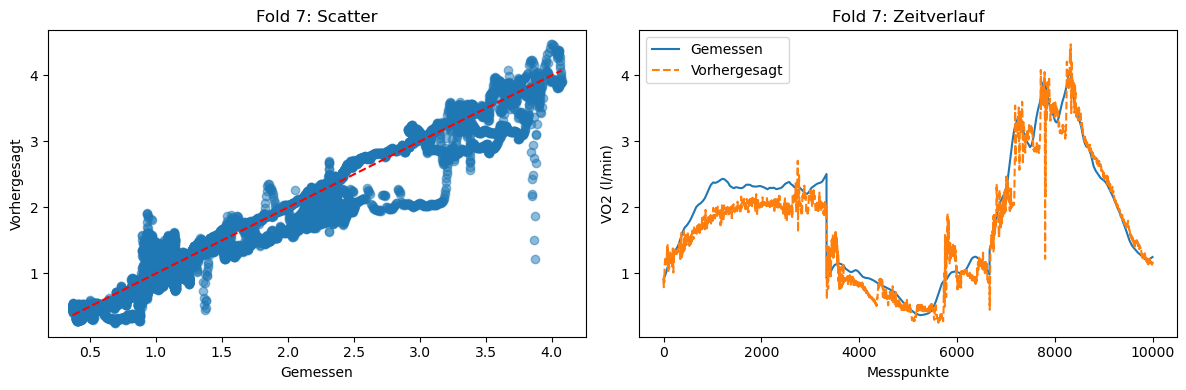

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  8 – Proband 8:
 RMSE = 0.805,  R2 = 0.501,  MAPE = 26.43%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


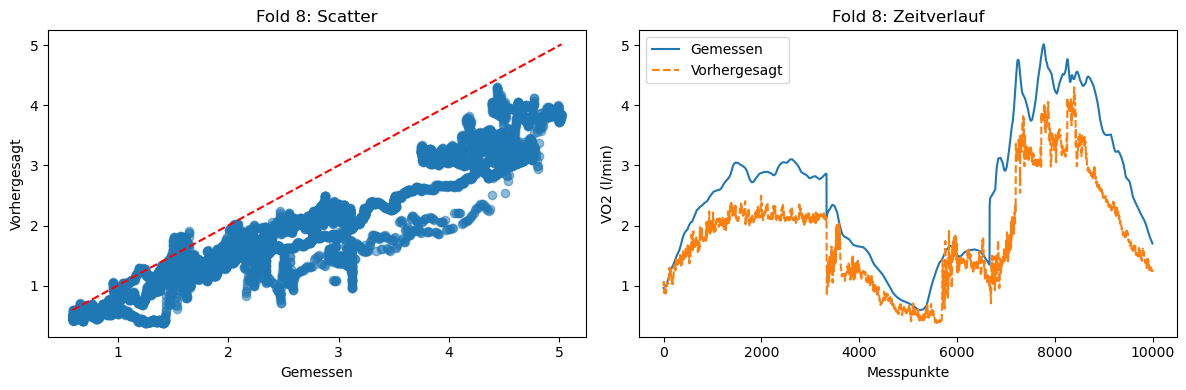

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold  9 – Proband 9:
 RMSE = 0.580,  R2 = 0.593,  MAPE = 26.92%
 Beste Parameter: {'svr__C': 44.30375245218264, 'svr__epsilon': 0.2603162782303468, 'svr__gamma': 0.006431172050131994}


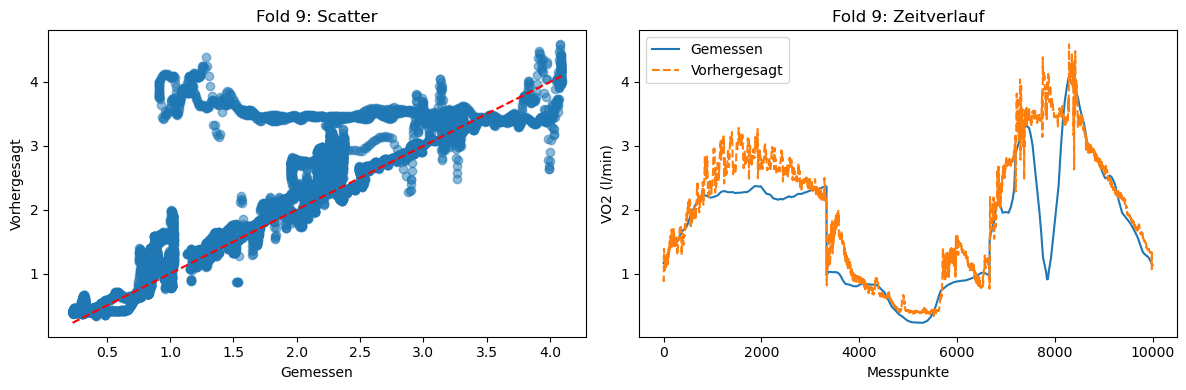

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 10 – Proband 10:
 RMSE = 0.396,  R2 = 0.835,  MAPE = 21.37%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


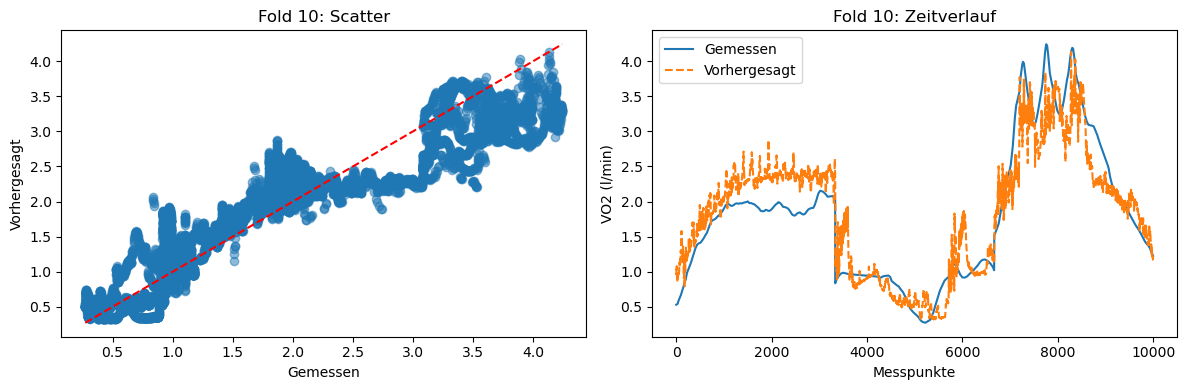

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 11 – Proband 11:
 RMSE = 0.466,  R2 = 0.788,  MAPE = 19.41%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


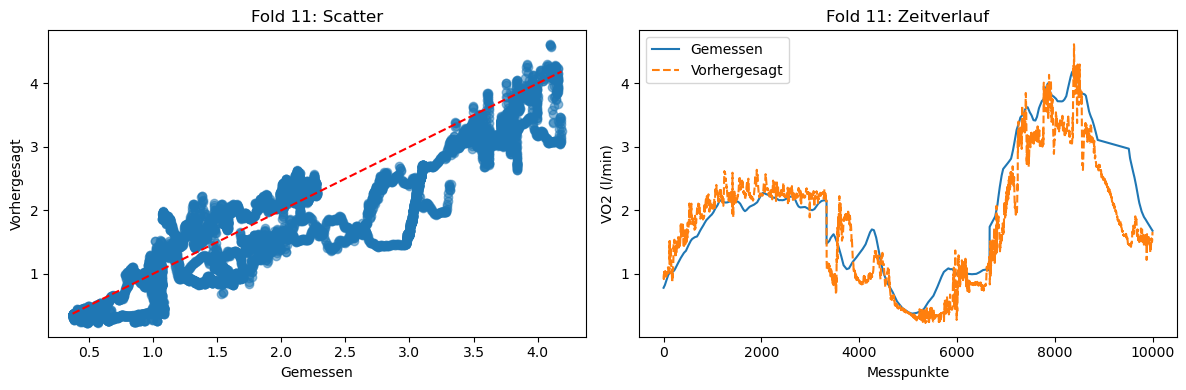

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fold 12 – Proband 12:
 RMSE = 0.519,  R2 = 0.723,  MAPE = 16.89%
 Beste Parameter: {'svr__C': 1.8255254802399, 'svr__epsilon': 0.017076439104114, 'svr__gamma': 0.03146730406166007}


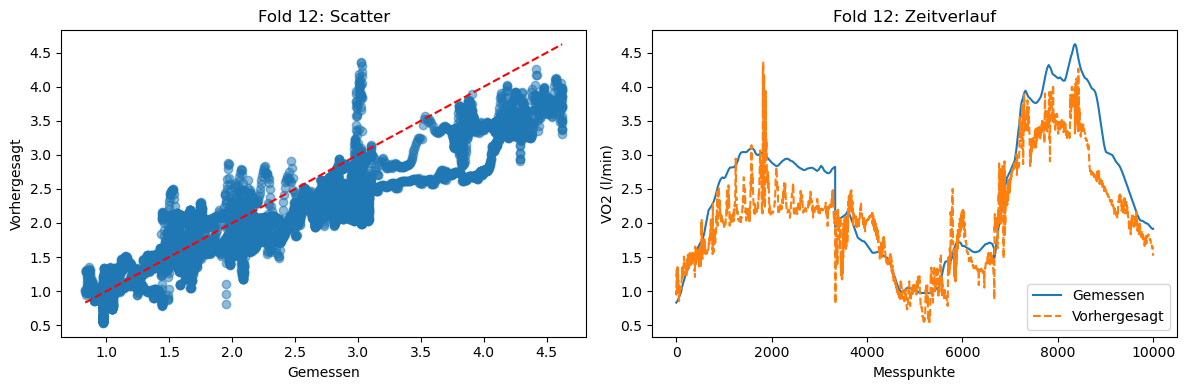

In [6]:
rmse_liste, r2_liste, mape_liste = [], [], []
y_alleWahre, y_alleVorhersage = [], []

Leave = LeaveOneGroupOut()

for fold, (train, test) in enumerate(Leave.split(X, y, gruppen), 1):
    suche.fit(X[train], y[train], groups=gruppen[train])
    y_pred = suche.predict(X[test])
    y_true = y[test]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    rmse_liste.append(rmse)
    r2_liste.append(r2)
    mape_liste.append(mape)
    y_alleWahre.extend(y_true)
    y_alleVorhersage.extend(y_pred)

    print(f"Fold {fold:2d} – Proband {gruppen[test][0]}:")
    print(f" RMSE = {rmse:.3f},  R2 = {r2:.3f},  MAPE = {mape:.2f}%")
    print(f" Beste Parameter: {suche.best_params_}")

    # Plot pro Fold
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "r--")
    plt.xlabel("Gemessen"); plt.ylabel("Vorhergesagt")
    plt.title(f"Fold {fold}: Scatter")

    plt.subplot(1, 2, 2)
    plt.plot(y_true, label="Gemessen")
    plt.plot(y_pred, "--", label="Vorhergesagt")
    plt.xlabel("Messpunkte"); plt.ylabel("VO2 (l/min)")
    plt.title(f"Fold {fold}: Zeitverlauf")
    plt.legend(); plt.tight_layout(); plt.show()

=== Gesamtergebnisse über alle Folds ===
RMSE: 0.511
R²  : 0.734
MAPE: 23.19%


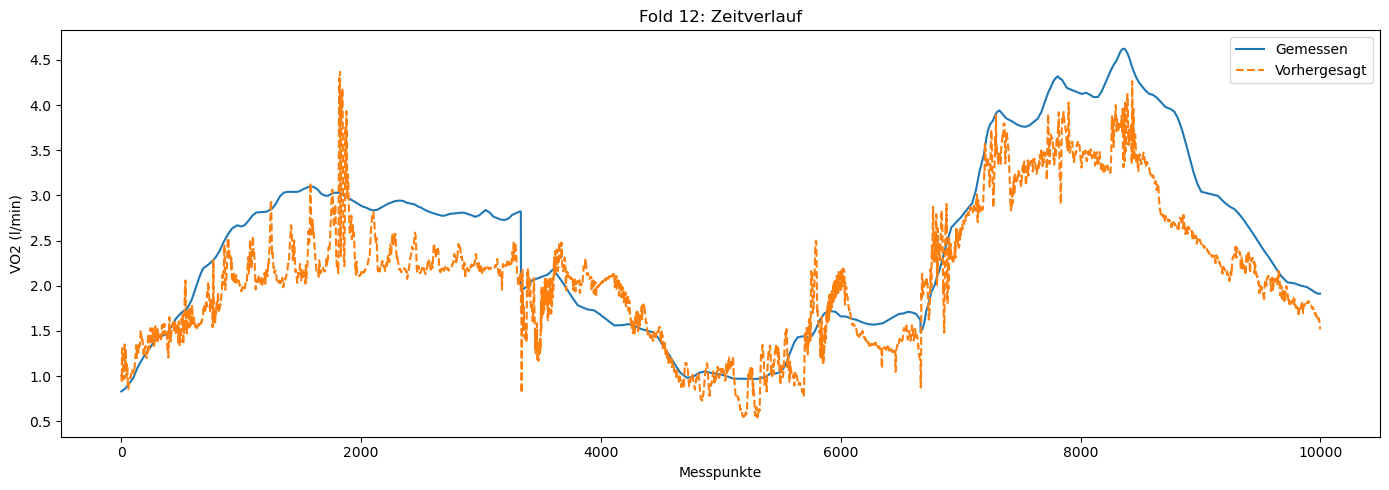

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# In numpy umwandeln
y_all_true = np.array(y_alleWahre)
y_all_pred = np.array(y_alleVorhersage)

# Gesamte Metriken berechnen
rmse_total = np.sqrt(mean_squared_error(y_all_true, y_all_pred))
r2_total = r2_score(y_all_true, y_all_pred)
mape_total = mean_absolute_percentage_error(y_all_true, y_all_pred) * 100

print("=== Gesamtergebnisse über alle Folds ===")
print(f"RMSE: {rmse_total:.3f}")
print(f"R²  : {r2_total:.3f}")
print(f"MAPE: {mape_total:.2f}%")

# Nur Zeitverlauf pro Fold
plt.figure(figsize=(14, 5))
plt.plot(y_true, label="Gemessen")
plt.plot(y_pred, "--", label="Vorhergesagt")
plt.xlabel("Messpunkte")
plt.ylabel("VO2 (l/min)")
plt.title(f"Fold {fold}: Zeitverlauf")
plt.legend()
plt.tight_layout()
plt.show()

